In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from argparse import Namespace
from glob import glob

from sklearn.decomposition import PCA

In [2]:
from maskrcnn.postprocess.validate import K, plot_scatter

In [3]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)

In [4]:
# image index data
IDX_IN_DIR = 'data/Experiment0/aoi.csv'
# download log data
LOG_IN_DIR = 'data/Experiment0/aoi_download_log.csv'

# census data
CEN_IN_DIR = 'data/Experiment0/census.csv'

# satellite derived data
SAT_IN_DIR = 'data/Mexico/Pred/infer/'

# output path
OUT_DIR = 'data/Experiment0/Output/'

SAMPLE_NAME = '2019Oct9'

# set up visualization cfg
cfg = Namespace()
cfg.visual_score_cutoff = 0.9
cfg.xmax = 480
cfg.ymax = 770

In [5]:
# renamed columns in census, translate to English
CEN_COLS = {
    'POBTOT': 'cen_pop',
    'VIVTOT': 'cen_house',
    'TVIVHAB': 'cen_inhab',
    'asset_score1': 'cen_asset_score1',
    'asset_score2': 'cen_asset_score2',
    'asset_score3': 'cen_asset_score3',
    'VPH_SNBIEN': 'cen_nodurable',
    'VPH_1CUART': 'cen_1room',
    'VPH_3YMASC': 'cen_3plusroom',
    'VPH_REFRI': 'cen_refri',
    'VPH_AUTOM': 'cen_autom',
    'VPH_C_ELEC': 'cen_elec',
    'VPH_PISODT': 'cen_floor',
    'VPH_AGUADV': 'cen_water',
    'VPH_EXCSA': 'cen_toilet',
    'VPH_DRENAJ': 'cen_drainage',
    'VPH_INTER': 'cen_internet'
}

In [6]:
# read image index data frame
df_idx = pd.merge(pd.read_csv(IDX_IN_DIR),
                  pd.read_csv(LOG_IN_DIR),
                  how='outer', on='index')
df_idx = df_idx.loc[:, ['index', 'ent', 'mun', 'loc', 'chip',
                        'status', 'lon_min', 'lon_max', 'lat_min', 'lat_max']]

In [7]:
# read census data
df_cen = pd.read_csv(CEN_IN_DIR)

# drop NA localities with no images
df_cen = pd.merge(
    df_cen,
    df_idx.groupby(['ent', 'mun', 'loc']).agg(
        no_missing=pd.NamedAgg(column='status',
                               aggfunc=lambda x: sum(pd.isna(x)))),
    how='outer',
    on=['ent', 'mun', 'loc'])
df_cen = df_cen.loc[df_cen['no_missing'] == 0, :]

In [8]:
# compute asset score
vph_cols = [col for col in df_cen.columns if col.startswith('VPH')]
m = PCA(n_components=3)
df_cen = pd.concat([
    df_cen.reset_index(drop=True),
    pd.DataFrame(m.fit_transform(df_cen.loc[:, vph_cols].values),
                 columns=['asset_score1', 'asset_score2', 'asset_score3'])],
    axis=1)
df_cen['asset_score1'] = - df_cen['asset_score1']

In [9]:
# rename and select columns
df_cen = (df_cen.loc[:, ['ent', 'mun', 'loc', 'sample'] + list(CEN_COLS.keys())]
                .rename(columns=CEN_COLS))

In [11]:
# read satellite predictions
# from json annotations
df_sat = []
for file_name in glob(SAT_IN_DIR + '*.json'):
    with open(file_name, 'r') as f:
        df_sat += json.load(f)
df_sat = pd.DataFrame(df_sat)

# drop low score predictions
df_sat = df_sat.loc[df_sat['score'] > cfg.visual_score_cutoff, :]

# drop predictions on logos
df_sat = pd.concat([
    df_sat.reset_index(drop=True),
    pd.DataFrame(df_sat['bbox'].values.tolist(),
                 columns=['xmin', 'ymin', 'width', 'height'])],
    axis=1)
df_sat = df_sat.loc[~((df_sat['xmin'] > cfg.xmax) & (df_sat['ymin'] > cfg.ymax)), :]

In [12]:
# merge with locality identifiers
df_sat = pd.merge(df_idx, df_sat,
                  how='right', left_on='index', right_on='image_id_str')

In [13]:
# calculate centroid
# remember that the lon/lat min/max are the chip bbox, not the instance bbox
# the following is instance centroid
df_sat['lon_center'] = (df_sat['lon_min'] +
    (df_sat['xmin'] + df_sat['width'] / 2) / 800 *
    (df_sat['lon_max'] - df_sat['lon_min']))
df_sat['lat_center'] = (df_sat['lat_max'] -
    (df_sat['ymin'] + df_sat['height'] / 2) / 800 *
    (df_sat['lat_max'] - df_sat['lat_min']))

In [14]:
# grouping into localities
df_group = df_sat.groupby(['ent', 'mun', 'loc']).agg(
    sat_house=pd.NamedAgg(column='score', aggfunc='count'),
    sat_size_mean=pd.NamedAgg(column='area', aggfunc=np.nanmean),
    sat_size_std=pd.NamedAgg(column='area', aggfunc=np.nanstd),
    sat_size_sum=pd.NamedAgg(column='area', aggfunc=np.nansum)
)
# calculate K function values
tile_size = 1.6545e-03
for i, col in zip([.5, 1, 1.5],
                  ['sat_dist_h05', 'sat_dist_h10', 'sat_dist_h15']):
    df_group[col] = df_sat.groupby(['ent', 'mun', 'loc']).apply(
        lambda grp: K(grp[['lon_center', 'lat_center']].values,
                      A=(tile_size ** 2) * 25, h=tile_size * i))

# scale areas / distances
df_group[[col for col in df_group.columns if col.startswith('sat_size')]] *= (
    (0.298 ** 2) * (640 ** 2) / (800 ** 2) * np.cos(23 / 180 * np.pi))  # in sq meters
df_group[[col for col in df_group.columns if col.startswith('sat_dist')]] *= (
    0.298 * 640 / 800 * (1 + np.cos(23 / 180 * np.pi)) / 2)  # in meters

In [15]:
# drop outliers
df_group = df_group.loc[
    ((df_group['sat_size_mean'] <= df_group['sat_size_mean'].quantile(q=0.97)) &
     (df_group['sat_house'] <= df_group['sat_house'].quantile(q=0.97))), :]

In [16]:
# merge satellite and census
df_group = pd.merge(
    df_group,
    df_cen,
    how='inner', on=['ent', 'mun', 'loc'])

In [17]:
# select sample
df_group = df_group.loc[df_group['sample'] == SAMPLE_NAME, :]

In [18]:
# massive plotting begins
sat_cols = [col for col in df_group.columns if col.startswith('sat')]
cen_cols = [col for col in df_group.columns if col.startswith('cen')]
for sat_col in sat_cols:
    for cen_col in cen_cols:
        plot_scatter(col_x_key=cen_col, col_y_key=sat_col,
                     col_x_label=cen_col, col_y_label=sat_col,
                     df=df_group, out_dir=OUT_DIR)

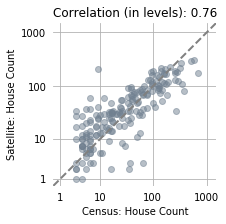

In [19]:
# hand-picked figures
plot_scatter(
    col_x_key='cen_house',
    col_x_label='Census: House Count',
    transform_x=lambda x: np.log10(x + 1),
    xlim=(np.log10(0 + 1.5), np.log10(1000 + 500)),
    xticks=[np.log10(1 + 1), np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    xticklabels=[1, 10, 100, 1000],
    col_y_key='sat_house',
    col_y_label='Satellite: House Count',
    transform_y=lambda x: np.log10(x + 1),
    ylim=(np.log10(0 + 1.5), np.log10(1000 + 500)),
    yticks=[np.log10(1 + 1), np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    yticklabels=[1, 10, 100, 1000],
    square=True, df=df_group, out_dir=OUT_DIR, show=True)

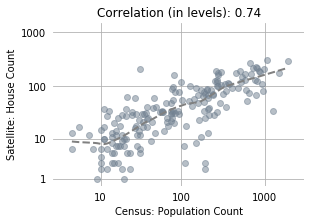

In [20]:
plot_scatter(
    col_x_key='cen_pop',
    col_x_label='Census: Population Count',
    transform_x=lambda x: np.log10(x + 1),
    xlim=(np.log10(3), np.log10(3000)),
    xticks=[np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    xticklabels=[10, 100, 1000],
    col_y_key='sat_house',
    col_y_label='Satellite: House Count',
    transform_y=lambda x: np.log10(x + 1),
    ylim=(np.log10(0 + 1.5), np.log10(1000 + 500)),
    yticks=[np.log10(1 + 1), np.log10(10 + 1), np.log10(100 + 1), np.log10(1000 + 1)],
    yticklabels=[1, 10, 100, 1000],
    line=True, df=df_group, out_dir=OUT_DIR, show=True)

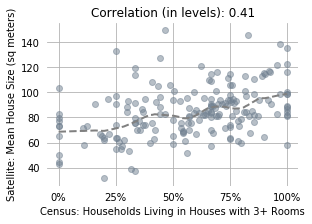

In [21]:
plot_scatter(
    col_x_key='cen_3plusroom',
    col_x_label='Census: Households Living in Houses with 3+ Rooms',
    xticks=[0, .25, .5, .75, 1],
    xticklabels=['0%', '25%', '50%', '75%', '100%'],
    col_y_key='sat_size_mean',
    col_y_label='Satellite: Mean House Size (sq meters)',
    line=True, df=df_group, out_dir=OUT_DIR, show=True)

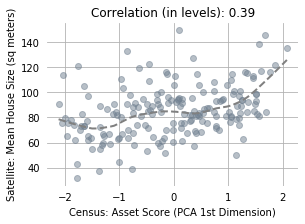

In [22]:
plot_scatter(
    col_x_key='cen_asset_score1',
    col_x_label='Census: Asset Score (PCA 1st Dimension)',
    col_y_key='sat_size_mean',
    col_y_label='Satellite: Mean House Size (sq meters)',
    line=True, df=df_group, out_dir=OUT_DIR, show=True)

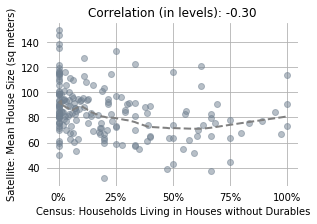

In [23]:
plot_scatter(
    col_x_key='cen_nodurable',
    col_x_label='Census: Households Living in Houses without Durables',
    xticks=[0, .25, .5, .75, 1],
    xticklabels=['0%', '25%', '50%', '75%', '100%'],
    col_y_key='sat_size_mean',
    col_y_label='Satellite: Mean House Size (sq meters)',
    line=True, df=df_group, out_dir=OUT_DIR, show=True)